<a href="https://colab.research.google.com/github/vjacobsen/Liquor-Sales-Forecasting/blob/main/Liquor_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

### Provide your credentials to the runtime
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

## Optional: Enable data table display
%load_ext google.colab.data_table

Authenticated


## BigCoud Query

In [2]:
# Set up BigQuery client
project_id = 'iowa-liquor-sales-266301'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

In [3]:
sales_data = client.query('''

SELECT 
date, 
item_number,
item_description,
vendor_number, 
category_name, 
SUM(sale_dollars) as sales_amount, 
SUM(bottles_sold) as sales_bottles,
CAST(EXTRACT(YEAR FROM date) as string) as year,
CAST(EXTRACT(WEEK FROM date) as string) as week,
CAST(EXTRACT(MONTH FROM date) as string) as month 

FROM `bigquery-public-data.iowa_liquor_sales.sales`

WHERE 
date > DATE_SUB(
  (SELECT MAX(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`), 
INTERVAL 4 YEAR) AND 
#store_name LIKE "%Wal-Mart%" AND
vendor_number = '421'

GROUP BY
date, 
item_number,
sale_dollars, 
vendor_number, 
category_name, 
item_description

''').to_dataframe()

sales_data.sample(5)

,date,item_number,item_description,vendor_number,category_name,sales_amount,sales_bottles,year,week,month
74111,2016-12-06,36976,Nikolai Vodka,421,American Vodkas,117.84,24,2016,49,12
247309,2020-07-27,86886,Southern Comfort,421,Whiskey Liqueur,77.50,5,2020,30,7
148602,2018-04-24,64870,Fireball Cinnamon,421,American Cordials & Liqueur,648.00,480,2018,16,4
53327,2018-03-08,12856,Rich & Rare Reserve,421,Canadian Whiskies,39.00,4,2018,9,3
26695,2019-04-24,73140,Chila Orchata,421,Cream Liqueurs,39.03,3,2019,16,4


## Data Preprocessing

In [4]:
# Rename columns
sales_data = sales_data.rename(columns={'sales_amount':'sales_dollars'})

# Create forecast key
sales_data['forecast_key'] = sales_data['item_number']

# Convert date to date
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Number of unique keys
print("Number of items:", len(sales_data['item_number'].unique()))

mapping_table = sales_data.drop_duplicates('forecast_key')[['item_number',
                                                            'category_name',
                                                            'item_description',
                                                            'forecast_key',
                                                            'vendor_number']].set_index('forecast_key')
mapping_table.head(5)

Number of items: 369


,item_number,category_name,item_description,vendor_number
forecast_key,,,,
76436,76436,None,Old St. Nick's Egg Nog,421
903563,903563,Special Order Items,Rain Vodka,421
86637,86637,Triple Sec,Tortilla Triple Sec,421
100015,100015,None,Fireball Bag in Box,421
42167,42167,Aged Dark Rum,Myers's Original Dark Rum,421


### Expand missing dates 



In [5]:
from IPython.display import clear_output

# Create continuous date range for forecasts


def date_populator(df):
  first_date = df['date'].min()
  current_dates = pd.date_range(first_date, last_date)
  current_dates = pd.DataFrame(current_dates)
  current_dates['type'] = 'historical'
  current_dates = current_dates.rename(columns={0:'date'})
  df = df.merge(current_dates, on='date',how='right')

  return df

last_date = sales_data['date'].max()
print(last_date)

sales_data = sales_data.groupby('forecast_key').apply(date_populator)

sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data = sales_data.drop(columns=['forecast_key'])
sales_data = sales_data.reset_index()

# Year_Week key
sales_data['year_week'] = (sales_data['date'].dt.year.astype(str) + "_" + sales_data['date'].dt.isocalendar().week.astype(str))

2020-10-30 00:00:00


In [6]:
# Drop last week and first week (might have incomplete data)
latest_week = sales_data[sales_data['date']==sales_data['date'].max()]['year_week'].values[0]
earliest_week = sales_data[sales_data['date']==sales_data['date'].min()]['year_week'].values[0]
print(earliest_week,latest_week)


sales_data = sales_data[((sales_data['year_week']!=earliest_week) & 
                         (sales_data['year_week']!=latest_week)
                         )].copy()

2016_44 2020_44


In [7]:
# Fill NA values
sales_data['sales_bottles'] = sales_data['sales_bottles'].fillna(0)

### Generate future data to forecast

In [8]:
# Create date range for forecasts, 6 months forward looking

weeks_to_forecast = 52

print(last_date)

forecast_future_dates = pd.date_range(last_date, 
                                      last_date + np.timedelta64(weeks_to_forecast,'W') 
                                      )

forecast_future_dates = pd.DataFrame(forecast_future_dates)
forecast_future_dates['type'] = 'forecast'
forecast_future_dates = forecast_future_dates.rename(columns={0:'date'})
forecast_future_dates['date'] = forecast_future_dates['date'].dt.date

forecast_future_dates['merge_dates'] = 'merge'

sales_data['merge_dates'] = 'merge'
unique_keys = sales_data.drop_duplicates('forecast_key')[['merge_dates','forecast_key']]

# Add forecasts to sales data
sales_data = sales_data.append(unique_keys.merge(forecast_future_dates))

sales_data.drop(columns='merge_dates',inplace=True)

sales_data['date'] = pd.to_datetime(sales_data['date'])

2020-10-30 00:00:00


## Feature Engineering

In [9]:
# Variable to forecast
target_value = 'sales_bottles'

### Weeks since start of sales

In [10]:
# Weeks since start of sales
date_column = 'date'
first_dates = sales_data.groupby('forecast_key')[date_column].min().to_dict()

sales_data['first_date'] = [first_dates.get(x) for x in sales_data['forecast_key']]

sales_data['trend']  = sales_data['date'] - sales_data['first_date'] # days difference
sales_data['trend'] = sales_data['trend']/np.timedelta64(1,'W') # convert to weeks
sales_data['trend'] = np.ceil(sales_data['trend']) # round up

# Drop uneeded columns
sales_data = sales_data[['forecast_key',target_value,'date','trend','type']]

### Date features


In [11]:
sales_data['month'] = sales_data['date'].dt.month
sales_data['year'] = sales_data['date'].dt.year
sales_data['week'] = sales_data['date'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Holidays
Holidays are an important factor that drive sales. The week before and week after holidays might also have increased demand.

In [12]:
import holidays

# US holiday dictionary
us_holidays = holidays.UnitedStates()

# Is day a holiday?
sales_data['is_holiday'] = [date in us_holidays for date in sales_data['date']]
sales_data['is_holiday'] = sales_data['is_holiday'].astype(int)

# Is week before a holiday?
sales_data['week_before_holiday'] = [date in us_holidays for date in (sales_data['date']-np.timedelta64(1,'W'))]
sales_data['week_before_holiday'] = sales_data['week_before_holiday'].astype(int)

# Is week after a holiday?
sales_data['week_after_holiday'] = [date in us_holidays for date in (sales_data['date']+np.timedelta64(1,'W'))]
sales_data['week_after_holiday'] = sales_data['week_after_holiday'].astype(int)


In [13]:
# Convert int64 cols to str
sales_data = pd.concat([sales_data.select_dtypes(exclude=['int']), 
                        sales_data.select_dtypes(include=['int']).astype(str)],
                       axis=1)

### Group By Week

In [14]:
# Group by week 
target_field_sum = sales_data.groupby(['forecast_key','year','week'])[target_value].sum()
features_max = sales_data.groupby(['forecast_key','year','week']).max().drop(columns=[target_value])
processed_dataset = features_max.join(target_field_sum).reset_index()       


## Segment Keys
Intermittent, discontinued, new or normal. Two rules used:


If sales in the last 3 months are 0, product is discontinued

If % of weeks with 0 demand over total weeks is greater than 1.32, sales are intermittent. 
ADI is given by calculating 


```
ADI = Total Number of Periods/Number of Periods with Sales
```




In [15]:
from tqdm import tqdm
tqdm.pandas()

predicted_var = target_value

zero_sales_periods_cutoff = 12 # weeks of zero sales to classify discontinued

def series_classifier(key_group):
  key_group = key_group[key_group['type']=='historical'] # only historical data

  # Average Demand Interval
  zero_sales_weeks = key_group[key_group[predicted_var]==0][predicted_var].count()
  total_weeks = key_group[predicted_var].count() 
  adi = total_weeks/(total_weeks - zero_sales_weeks) # average demand interval

  # Inttermittence
  date_cutoff = key_group['date'].max() - pd.Timedelta(zero_sales_periods_cutoff,unit='w')
  last_12_weeks_df = key_group[key_group['date'] > date_cutoff]
  last_12_weeks_sales = last_12_weeks_df[predicted_var].sum() 

  # Classify key
  if last_12_weeks_sales==0:
    return "discontinued"

  elif adi>1.32:
    return "intermittent"

  elif len(key_group)<52:
    return "new"

  else:
    return "normal"

classified_keys = processed_dataset.groupby('forecast_key').apply(series_classifier)
classified_keys.name = "key_class"

processed_dataset = processed_dataset.merge(classified_keys,
                                            how='left',
                                            left_on='forecast_key',
                                            right_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in long_scalars
  


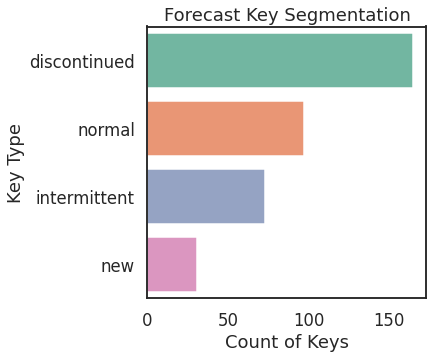

In [16]:
sns.set(style="white")
sns.set_context("talk")
sns.set_palette("Set2")

f, ax = plt.subplots(figsize=(5, 5))

plot_df = classified_keys.value_counts().to_frame()

sns.barplot(x=plot_df['key_class'],y=plot_df.index,)

ax.set(xlabel='Count of Keys', ylabel='Key Type')
plt.title("Forecast Key Segmentation")
plt.show()

In [17]:
# Subset keys to disco and intermittent only
processed_dataset = processed_dataset[processed_dataset['key_class']!='discontinued']

# Forecasting

## Data set up

In [18]:
# Identify date columns
date_column = 'date'

# Select features to include in model run. Can also include "month"
features = ['month',
            'is_holiday', 
            'week_before_holiday', 
            'week_after_holiday', 
            'trend']

#target variable to be predicted
predicted_var = [target_value]

#staging variables to subset dataset to features
y_cols = predicted_var + ['type']
x_cols = features + ['type']

## SciKit Machine Learning

In [19]:
# Import
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet, ElasticNetCV, RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, PowerTransformer, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer,make_column_selector,TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn import linear_model, metrics
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from datetime import datetime, timedelta, date

from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import uniform, randint
import statsmodels.api as sm
from pylab import rcParams

import math
import warnings
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # linear algebra

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Machine Learning Models and Pipelines

In [20]:
### Pipelines

# For ElasticNet, we'll one hot encode data. For XGBoost we only need to label encode.
# ElasticNet will need to have interaction features created
# Pipelines for different types are created and then combined into a column transformer that will feed into final pipeline

# Feature transformers
numeric_transformer = Pipeline([('scaler',StandardScaler())
                                #('interactions',PolynomialFeatures(interaction_only=True))
                                ])

categorical_transformer = Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])

# Preprocessor
preprocessor = make_column_transformer((numeric_transformer, make_column_selector(dtype_exclude='object')),
                                       (categorical_transformer, make_column_selector(dtype_include='object')),
                                       sparse_threshold=0)

#XGBoost
pipe_xgboost = Pipeline([('xgb', xgb.XGBRegressor(objective="reg:squarederror"))])

# ElasticNet
pipe_elasticnet = Pipeline([('elnt', ElasticNet())])

# Target Transformed XGBoost
tt = TransformedTargetRegressor(regressor=xgb.XGBRegressor(objective="reg:squarederror"), 
                                transformer=PowerTransformer(standardize=False))
pipe_xgb_transf = Pipeline([('xgb_tt', tt)])

# KNN Regressor
pipe_knn = Pipeline([('knn',KNeighborsRegressor())])


# Parameters

# XGBoost
xgb_params = {"xgb__colsample_bytree": uniform(0.7, 0.3),
          "xgb__gamma": uniform(0, 0.5),
          "xgb__learning_rate": uniform(0.003, 0.3), # default 0.1 
          "xgb__max_depth": randint(2, 3), # default 3
          "xgb__n_estimators": randint(100, 250), # default 100
          "xgb__subsample": uniform(0.6, 0.4)}

# Target Transformed XGBoost 
xgb_tt_params = {"xgb_tt__regressor__colsample_bytree": uniform(0.7, 0.3),
          "xgb_tt__regressor__gamma": uniform(0, 0.5),
          "xgb_tt__regressor__learning_rate": uniform(0.003, 0.3), # default 0.1 
          "xgb_tt__regressor__max_depth": randint(2, 3), # default 3
          "xgb_tt__regressor__n_estimators": randint(100, 250), # default 100
          "xgb_tt__regressor__subsample": uniform(0.6, 0.4)}

fit_params = {}#{'early_stopping_rounds':5}

# ElasticNet
elnt_l1_params = [.1, .5, .7, .9, .95, .99, 1]
elnt_alphas_params = [0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.]
elnt_params = [{'elnt__l1_ratio':elnt_l1_params,'elnt__alpha':elnt_alphas_params}]

# KNN
n_neighbors = [2,3,4,5]
knn_params = [{'knn__n_neighbors':n_neighbors}]


# Search pipes

jobs=-1

time_split = TimeSeriesSplit(n_splits = 3)

rs_xgb =  RandomizedSearchCV(estimator=pipe_xgboost, 
                             param_distributions=xgb_params,
                             random_state=42, 
                             n_iter=4, 
                             cv=time_split, 
                             n_jobs=jobs, 
                             return_train_score=True,
                             scoring='neg_mean_squared_error')

rs_xgb_tt =  RandomizedSearchCV(estimator=pipe_xgb_transf, 
                             param_distributions=xgb_tt_params,
                             random_state=42, 
                             n_iter=4, 
                             cv=time_split, 
                             n_jobs=jobs, 
                             return_train_score=True,
                             scoring='neg_mean_squared_error')

gs_elnt = GridSearchCV(estimator=pipe_elasticnet,
                    param_grid=elnt_params,
                    cv=4,
                    scoring='neg_mean_squared_error',
                    n_jobs=jobs)


gs_knn = GridSearchCV(estimator=pipe_knn,
                     param_grid=knn_params,
                     cv=4,
                     scoring='neg_mean_squared_error',
                     n_jobs=jobs)

# ELasticNet with builtin CV
elntcv = ElasticNetCV(cv=4, 
                      random_state=42, 
                      l1_ratio = [.1, .5, .7, .9, .95, .99, 1], 
                      alphas=[0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])

elntcv_tt = TransformedTargetRegressor(regressor=elntcv, 
                                       transformer=PowerTransformer(standardize=False,method='yeo-johnson'))


# Auxiliary lists and dictionaries for batch forecasting

# List of pipelines for iteration
cv_searchers = [elntcv, rs_xgb, gs_knn, rs_xgb, elntcv, elntcv_tt,rs_xgb_tt]

# Dictionary of pipelines and classifier types for ease of reference
cv_search_dict = {0:'ElasticNet', 1:'XGBoost', 2:'KNN',3:'XGBoost_Trended',
                  4:'ElasticNet_Trended',5:'ElntCV_tt_Trended',6:'XGB_tt_Trended'}

trended_non_trend_cutoff = 3 # this is the position of the first trended model in cv_search_dict

## Dataset prep

In [21]:
def train_test(X, Y, tst_size=0.20, time_aligned=True):
    
    first = X.index.min()
    last = X.index.max()
    
    global trim_date
    
    # subset train and test independent and dependent variables, split sequentially on trim date
    if time_aligned == True:
        
        delta = last - first
        weeks = (delta.days)/7 + 1
        train_weeks = round((1-tst_size)*weeks)
        test_weeks = round(tst_size*weeks)
        trim_date = last - timedelta(test_weeks*7)
        
        X_train = X.loc[X.index <= trim_date]
        x_test = X.loc[X.index > trim_date]
        Y_train = Y.loc[X.index <= trim_date]
        y_test = Y.loc[X.index > trim_date]

    else:
        X_train, x_test, Y_train, y_test = train_test_split(X, Y, random_state=42, test_size=tst_size)
    
    return X_train, x_test, Y_train, y_test


def split_input_historical(X, Y):
    
    Y = Y[Y['type'] == 'historical']
    Y = Y.drop(columns='type')
    x_forecast = X[X['type'] == 'forecast']
    X = X[X['type'] == 'historical']
    x_forecast = x_forecast.drop(columns='type')
    X = X.drop(columns='type')

    return X, Y, x_forecast


def dataset_prep(df):
    
    # separate dependent and independent variables
    Y = df[y_cols]
    X = df[x_cols]

    # split into historical and input
    X, Y, x_forecast = split_input_historical(X, Y)
     
    # train/test split
    X_train, x_test, Y_train, y_test = train_test(X, Y)
    
    return X_train, x_test, Y_train, y_test, x_forecast, X


def mape_score_2(y_pred, y_true):
    
    error = abs(y_true - y_pred)
    ape = error/y_true
    return round(np.average(abs(ape), weights=y_true), 2)


def isolate_trend(df,X_train,x_test,x_forecast):
    
    # Isolate trend variable
    trend_all = df['trend'].values.reshape(-1,1) # Trend components for all periods
    trend_historical = df[df['type']=='historical']['trend'].values.reshape(-1,1)
    trend_X_train = X_train['trend'].values.reshape(-1,1)
    trend_x_test = x_test['trend'].values.reshape(-1,1)
    trend_x_forecast = x_forecast['trend'].values.reshape(-1,1)

    # Remove trend feature from dataset
    X_train = X_train.drop(columns='trend')
    x_test = x_test.drop(columns='trend')
    x_forecast = x_forecast.drop(columns='trend')
    all_x = df[x_cols].drop(columns=['type','trend']) 
    
    return trend_all,trend_historical,trend_X_train,trend_x_test,trend_x_forecast,X_train,x_test,x_forecast,all_x
    

def detrend(df,trend_historical,trend_X_train,trend_x_test,Y_train,y_test):
     
    all_actuals = df[df['type']=='historical'][predicted_var].values
    trend = ransac.fit(trend_historical, all_actuals)
    
    # Detrend Y Train
    Y_train = Y_train - trend.predict(trend_X_train) 
    
    # Detrend Y test
    trend_test = trend.predict(trend_x_test)
    y_test = y_test - trend_test

    return Y_train,y_test,trend,all_actuals,trend_test
    
    
def plot_trend_graph(y_true,y_pred,trend_test,y_pred_no_trend):
    
    if idx>=trended_non_trend_cutoff:
        print('Trended Model', idx)                
        # Create basic plot
        df_for_trend_plot = pd.DataFrame(y_true)
        df_for_trend_plot['trended_pred'] = y_pred
        df_for_trend_plot['isolated_trend'] = trend_test
        df_for_trend_plot['detrended_pred'] = y_pred_no_trend
        df_for_trend_plot.plot(figsize=(15,5))
        
        return plt.show()


def train_test_mapper(row):
    
    if row['type']=='forecast':
        return 'forecast'
    elif row['trim_date']>=row[date_column]:
        return 'train'
    else:
        return 'test'

In [22]:
# Create ransac regressor to model trend
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(random_state=42)

## Batch forecaster (ML) functions

In [23]:
# This function takes in a dataframe with historical data, splits in train test, 
# runs model pipes and outputs best forecast and mape

# trended_non_trend_cutoff indicates the position of the first trended model
# in the model list 

def forecast_apply(data,trended_non_trend_cutoff=3,plot_trend=False): 
    
    global y_true,y_pred, best_forecast
    
    data = data.set_index(date_column) # Make sure index is date

    # Train/Test split
    X_train, x_test, Y_train, y_test, x_forecast, X = dataset_prep(data)
    
    # Actual sales
    y_true = y_test[predicted_var].values.reshape(1,-1)[0]

    # Filter out low data availabiltiy keys
    if len(X_train)>5 and len(x_test)>5 and len(x_forecast)>2:
        
        # Get trend components for each subset and drop Trend feature
        trend_all,trend_historical,trend_X_train,trend_x_test,\
        trend_x_forecast,X_train,x_test,x_forecast,all_x = isolate_trend(data,X_train,x_test,x_forecast)

        # Processor fit
        processor_fit = preprocessor.fit(X_train) # Preprocessor is previously defined

        # Processor transform
        processor_transform = processor_fit.transform(X_train)

        X_train = (processor_fit.transform(X_train))
        x_test = (processor_fit.transform(x_test))
        x_forecast = (processor_fit.transform(x_forecast))
        all_x = (processor_fit.transform(all_x))

        # Initialize loop variables
        best_score = 10000000000
        best_model = ''

        # Loop through model dict to find best model
        for idx, searchcv in enumerate(cv_searchers):
          try:  
            # Detrend data for specific models. Order matters! Trended models need to be last in cv_searchers dict
            # Fit and Detrend, we use all historical data for this to capture overall trend.

            if idx==trended_non_trend_cutoff: 
                # Detrended Y is given by subtracting Trend from Y_true   
                Y_train,y_test,trend,all_actuals,trend_test = detrend(data,trend_historical,trend_X_train,trend_x_test,Y_train,y_test)

            # Fit grid search
            searchcv.fit(X_train, Y_train)

            # Predict on test data with best params
            y_pred = searchcv.predict(x_test)
            
            # Auxiliary transformation for compatibility with models
            if len(y_pred.shape)>1:
                y_pred = y_pred.reshape(1,-1)[0]
            
            # Add trend back to prediction if model is trended
            if idx >= trended_non_trend_cutoff: 
                trend_test = trend.predict(trend_x_test).reshape(1,-1)[0]
                y_pred = y_pred + trend_test
            
            # Auxiliary transformation for compatibility with models
            if len(y_pred.shape)>1:
                y_pred = y_pred.reshape(1,-1)[0]
            
            # Calculate MAPE
            scoring = mape_score_2(y_true, y_pred)
            
            # Plot trend graph?
            if idx >= trended_non_trend_cutoff: 
                if plot_trend==True:
                    y_pred_no_trend = searchcv.predict(x_test)
                    print('Trended Model', cv_search_dict.get(idx))                
                    # Create basic plot
                    df_for_trend_plot = pd.DataFrame(y_true)
                    df_for_trend_plot['trended_pred'] = y_pred
                    df_for_trend_plot['isolated_trend'] = trend_test
                    df_for_trend_plot['detrended_pred'] = y_pred_no_trend

                    df_for_trend_plot.plot(figsize=(15,5))
                    plt.show()
            
            # Select best (lowest MAPE) model
            if scoring < best_score:
                best_score = scoring
                best_search = searchcv
                best_model = idx
                
                # Need to add trend back to predictions if trended model
                if best_model >= trended_non_trend_cutoff:
                    best_forecast = searchcv.predict(all_x) + trend.predict(trend_all).reshape(1,-1)[0]
                else:
                    best_forecast = searchcv.predict(all_x)
            
            # Set up resulting dataframe
            data['forecast'] = best_forecast
            data['mape'] = best_score
            data['best_model'] = cv_search_dict.get(best_model)
            data['trim_date'] = trim_date
          except:
            pass
        return_df = data[['forecast','mape','best_model','trim_date','type']]
        clear_output()
        return return_df

## Execute ML forecasts

In [24]:
# Progress bar set up
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

# Apply forecast function to each key
indv_forecast = processed_dataset.groupby(['forecast_key']).progress_apply(forecast_apply)

# Format results
indv_forecast = indv_forecast.reset_index()
indv_forecast['type'] = indv_forecast.apply(train_test_mapper,axis=1)

100%|██████████| 201/201 [03:14<00:00,  1.03it/s]


## Breakdown forecast to days

In [25]:
# Need to first map out the week ID to each date_week on forecasts
year_week_map = sales_data[['forecast_key','date','year','week']]
indv_forecast = indv_forecast.merge(year_week_map,on=['forecast_key','date'])

# Expand forecasts from weeks to days
days = sales_data[['forecast_key','date','is_holiday','year','week']]

# Forecast date is actually a week end indicator date
indv_forecast = indv_forecast.rename(columns={'date':'week_date'})
indv_forecast = indv_forecast.merge(days,on=['forecast_key','year','week'])

# Drop duplicates
indv_forecast = indv_forecast.drop_duplicates(subset=['forecast_key','date'])

# Breakdown weekly forecast to daily
indv_forecast['day_of_week'] = indv_forecast['date'].dt.weekday

def breakdown_fcst(row):
  if row['day_of_week'] <5:
    return round(row['forecast']/5,0)
  else:
    return 0

indv_forecast['forecast'] = indv_forecast.apply(breakdown_fcst,axis=1)

In [26]:
# Subsets
historical_predictions = indv_forecast[indv_forecast['type']!='forecast']
forecasts = indv_forecast[indv_forecast['type']=='forecast'].set_index('forecast_key')

In [27]:
historical_predictions.groupby(['year','week']).sum().to_csv('week_sales.csv')

## Data report

In [28]:
# Plots
import plotly.express as px

fig = px.line(processed_dataset.groupby(['date']).sum().reset_index(),
              x='date',
              y=target_value, 
              title='Historical Sales')
fig.show()


mape_df = indv_forecast.groupby('forecast_key').agg({'mape':'mean','forecast':sum})
print("Weighted MAPE:", np.average(mape_df['mape'],weights=mape_df['forecast']))

# Format and add attributes to tables
mape_df = mape_df.join(mapping_table)

Weighted MAPE: 0.19388069415610648


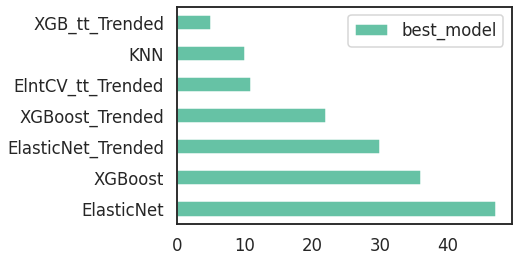

In [29]:
# show counts of best selected models
indv_forecast.groupby('forecast_key')['best_model'].agg(lambda x: stats.mode(x)[0]).value_counts().to_frame().plot(kind='barh')

plt.show()


# Export to BigQuery

In [30]:
historical_sales = sales_data[['date','forecast_key',target_value]]
historical_sales = historical_sales.groupby(['forecast_key','date']).sum().reset_index()

formatted_forecasts = indv_forecast.merge(historical_sales,
                                          on=['date','forecast_key'],
                                          how='left'
                                          )

formatted_forecasts = formatted_forecasts.set_index('forecast_key').join(mapping_table)
formatted_forecasts.sample(5)

,week_date,forecast,mape,best_model,trim_date,type,year,week,date,is_holiday,day_of_week,sales_bottles,item_number,category_name,item_description,vendor_number
forecast_key,,,,,,,,,,,,,,,,
989289,2020-04-05,0.0,-5.45,XGBoost,2020-07-19,train,2020,14,2020-04-05,0,6,0.0,989289,100% Agave Tequila,Kirkland Signature Tequila Silver,421
903835,2021-03-21,0.0,0.95,XGBoost,2020-01-12,forecast,2021,11,2021-03-17,0,2,0.0,903835,Special Order Items,Mount Royal Light Canadian Whisky,421
86916,2018-08-12,0.0,0.26,ElasticNet_Trended,2020-01-12,train,2018,32,2018-08-12,0,6,0.0,86916,Whiskey Liqueur,Southern Comfort 100prf,421
71886,2018-06-24,12.0,0.36,ElasticNet_Trended,2020-01-12,train,2018,25,2018-06-20,0,2,30.0,71886,American Cordials & Liqueur,Amaretto E Dolce,421
69715,2017-02-12,6.0,0.63,ElasticNet_Trended,2020-01-12,train,2017,6,2017-02-09,0,3,6.0,69715,Imported Schnapps,Dr McGillicuddys Peach,421


In [31]:
formatted_forecasts[target_value] =  formatted_forecasts[target_value].where(formatted_forecasts['type']!='forecast',np.nan)

In [32]:
# Save locally
mape_df[['mape']].to_csv('mape_df.csv')
formatted_forecasts.to_csv('forecasts.csv')

In [33]:
formatted_forecasts.type.value_counts()

train       138885
forecast     58765
test         34447
Name: type, dtype: int64

### Set up project and credentials

In [34]:
from google.cloud import bigquery

project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Construct a BigQuery client object.
client = bigquery.Client(project = project_id)

metrics_path = "/content/mape_df.csv"
forecasts_path = "/content/forecasts.csv"

file_paths = [metrics_path,forecasts_path]
table_names = ["ml_metrics","ml_forecasts"]

### Load tables

In [35]:
for file_path,tb_name in zip(file_paths,table_names):
  
  table_id = "{}.{}.{}".format(project_id,bq_dataset_name,tb_name)

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, 
      skip_leading_rows=1, 
      autodetect=True,
      
  )

  job_config.write_disposition = 'WRITE_TRUNCATE' 

  with open(file_path, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_id,job_config=job_config)
      
  job.result()  # Waits for the job to complete.

  table = client.get_table(table_id)  # Make an API request.

  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
  )

Loaded 161 rows and 2 columns to iowa-liquor-sales-266301.forecasting.ml_metrics
Loaded 232097 rows and 17 columns to iowa-liquor-sales-266301.forecasting.ml_forecasts


In [36]:
# Need to join actual sales
historical_predictions = historical_predictions.merge(processed_dataset[['forecast_key','date',target_value,'trend']],
                             how='left',
                             on=['date','forecast_key'])

# Random key report

In [37]:
sample_key = indv_forecast.forecast_key.sample().values[0]

In [38]:
sns.set_style('white')
sns.set_context('talk')

from sklearn.linear_model import RANSACRegressor,HuberRegressor, LinearRegression
ransac2 = RANSACRegressor(random_state=42)
huber = HuberRegressor()
lr = LinearRegression()

def plot_rand_key(rand=True):

  global data_actuals,trend_data
    
  key = specific_key
  if rand==True:
    key = pd.DataFrame(forecasts.index.unique()).sample().values[0][0]

  print(key)
  
  data_pred = dataset_weekly[dataset_weekly['forecast_key']==key].groupby('week_date').sum()
  data_fcst = forecasts.loc[key].groupby('week_date').sum()
  
  data_actuals = processed_dataset[(processed_dataset['forecast_key']==key) & (processed_dataset['type']!='forecast')]

  # Predict trendline 
  cols = ['date','trend'] + [predicted_var]
  
  trend_data = data_actuals.dropna()
  trend_y = trend_data[predicted_var[0]].values.reshape(-1,1)
  trend_x = trend_data['trend'].values.reshape(-1,1)
  trend_data['trend_line_huber'] = huber.fit(trend_x,trend_y).predict(trend_x)
  trend_data['trend_line_lr'] = lr.fit(trend_x,trend_y).predict(trend_x)
  
  try:
    trend_data['trend_line_ransac'] = ransac.fit(trend_x,trend_y).predict(trend_x)
  except: 
    trend_data['trend_line_ransac'] = 0
  
  trend_data['detrended_actuals'] = trend_data[predicted_var[0]] - trend_data['trend_line_ransac']
  
  # Power Transform
  trend_data['pt_actuals'] = PowerTransformer().fit_transform(trend_data['detrended_actuals'].values.reshape(-1,1))

  # Plot Time Series ----------------------------------------
  plt.figure(figsize=(16,7))

  # Actuals
  sns.lineplot(x="date", y=predicted_var[0],color="grey",linewidth=2,data=data_actuals)

  # Plot trend 
  #sns.lineplot(x='date', y='trend_line_ransac' ,color='lime', alpha=0.7, data=trend_data)
  #sns.lineplot(x='date', y='trend_line_huber' ,color='purple', alpha=0.7, data=trend_data)
  #sns.lineplot(x='date', y='trend_line_lr' ,color='turquoise', alpha=0.7, data=trend_data)

  # Add forecast 
  sns.lineplot(x="date", y='forecast',color='#42779B', alpha=1,linewidth=3, data=data_fcst)

  # Historical predictions 
  ##sns.lineplot(x="date", y='indv_forecast',hue='type', alpha=0.8, data=data_pred)
  sns.lineplot(x="date", y='forecast', color='#42779B', alpha=0.5, data=data_pred)

  plt.xticks(rotation=30)
  plt.title('Actuals vs Historical - {}'.format(key))
  #plt.legend(labels = ['Actuals','Ransac','Huber','LR', 'Best Forecast','Train','Test'])
  #plt.legend(labels = ['Actuals','Ransac', 'Best Forecast','Train','Test'])
  plt.legend(labels = ['Actuals', 'Forecast','Historical Prediction'])
  plt.show()

  # Histogram ---------------------------------------------
  plt.figure(figsize=(15,5))
  plt.subplot(1, 3, 1)
  sns.distplot(trend_data[predicted_var[0]],color='gray')
  plt.title('Original Sales Dist')

  plt.subplot(1, 3, 2)
  sns.distplot(trend_data['detrended_actuals'],color='purple')
  plt.title('Detrended Dist')

  plt.subplot(1, 3, 3)
  sns.distplot(trend_data['pt_actuals'],color='#42779B')
  plt.title('Detrended - Power Transformed')
  plt.tight_layout()
  plt.show()
  
  # Stationarize series plot
  fig, ax1 = plt.subplots(figsize=(12,5))
  ax1 = sns.lineplot(x="date", y=predicted_var[0],color='gray', alpha=0.6, data=trend_data)
  #ax1 = sns.lineplot(x="date", y='detrended_actuals',color='purple', alpha=0.5, data=trend_data)
  ax1.legend(['Actuals','Detrended'],loc='upper left')
  ax2 = ax1.twinx()
  ax2 = sns.lineplot(x="date", y='pt_actuals',color='#42779B', alpha=0.5, data=trend_data)
  ax2.legend(['Power Transformed'],loc='upper right')
  plt.show()

In [39]:
#Sample key
specific_key = '9432'
plot_rand_key(rand=True)

69634


NameError: ignored